In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataset import CustomDataset
from embedding_generator import EmbeddingGenerator
from torch.utils.data import DataLoader
from model import DinoV2_6channels
import torch
import random
import tifffile

def my_collate(batch):
    batch = [x for x in batch if x is not None]
    return torch.utils.data.dataloader.default_collate(batch)

# Dataset
test_dataset = CustomDataset('./Euro6datasetabs/val/')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=my_collate)

# Load pre-trained base model
base_model = DinoV2_6channels()
class_names = list(test_dataset.class_to_int.keys())

2024-01-09 09:36:00.622528: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 09:36:01.574275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 09:36:07.965743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of Dinov2Model were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized because the shapes did not match:
- embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 14, 14]) i

In [2]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def read_tiff(file_path):
    # Read the TIFF file
    image_stack = tifffile.imread(file_path)
    return image_stack

def extract_channels(image_stack, channel_names=None):
    # Check the shape of the image stack
    num_channels = image_stack.shape[0]
    
    # Extract individual channels
    channels = [image_stack[i, ...] for i in range(num_channels)]

    # Assign channel names if provided, otherwise use default names
    if channel_names is None:
        channel_names = [f'Channel {i + 1}' for i in range(num_channels)]

    return channels, channel_names

def imshow(inputs):
    image_stack = inputs

    # Specify channel names if available, otherwise set to None
    channel_names = ['R', 'G', 'B', 'NIR', 'SWIR1', 'SWIR2']  # Replace with actual channel names or set to None

    # Extract channels and names
    channels, channel_names = extract_channels(image_stack, channel_names)
    
    image = np.stack(channels[3:])
    plt.imshow(np.transpose(image/image.max(), (1, 2, 0)))
    plt.show()

In [3]:
device = "cuda"
def visualize_model(model, num_images=6):
    model = model.to(device)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader, start=100):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual:{class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

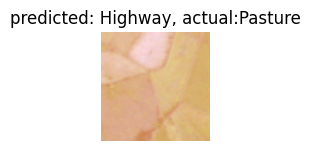

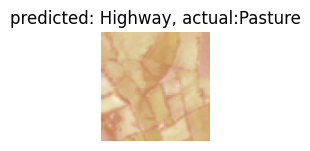

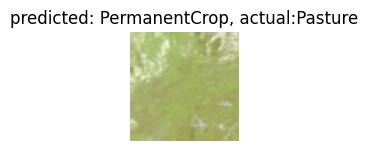

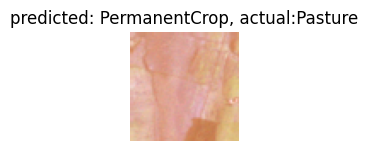

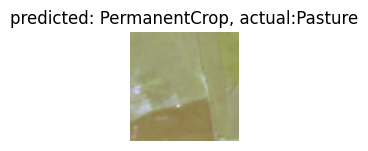

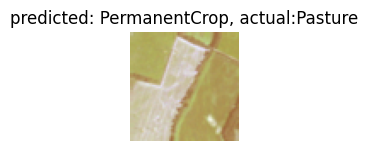

In [4]:
visualize_model(base_model)

In [5]:
# EmbeddingGenerator(base_model, '/home/ubuntu/home/ubuntu/6channel_training/dataset_satsure/6_channel_satsure_data/',
#                    '/home/ubuntu/home/ubuntu/6channel_training/embeddings_dinov2/embeddings_300_base-model.json')

In [6]:
# EmbeddingGenerator(base_model, '/home/ubuntu/home/ubuntu/6channel_training/dataset_satsure/satsure_6channel_lg/',
#                    '/home/ubuntu/home/ubuntu/6channel_training/embeddings_dinov2/embeddings_1500_base-model.json')

In [7]:
# EmbeddingGenerator(base_model, '/home/ubuntu/home/ubuntu/6channel_training/dataset_eurosat/val/',
#                    '/home/ubuntu/home/ubuntu/6channel_training/embeddings_dinov2/embeddings_eurosat_base-model.json')

In [9]:
EmbeddingGenerator(base_model, '/home/ubuntu/home/ubuntu/6channel_training/dataset_tiles/satsure_small_6channels',
                   '/home/ubuntu/home/ubuntu/6channel_training/embeddings_dinov2/embeddings_satsure_tiles_base-model_small.json')

cuda


images(4800):   1%|▊                                                                | 2/150 [00:01<01:11,  2.08it/s]/home/ubuntu/home/ubuntu/6channel_training/embedding_generator.py:59: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min())
images(4800): 100%|███████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.52it/s]


In [10]:
EmbeddingGenerator(base_model, '/home/ubuntu/home/ubuntu/6channel_training/dataset_tiles/satsure_large_6channels',
                   '/home/ubuntu/home/ubuntu/6channel_training/embeddings_dinov2/embeddings_satsure_tiles_base-model_large.json')

cuda


images(100720): 100%|███████████████████████████████████████████████████████████| 3148/3148 [07:43<00:00,  6.80it/s]
